In [4]:
import os
os.chdir('/home/jpmarceaux/Simulations/KalmanFiltering_Sandia2021')
from kalman_gst import *
os.chdir('/home/jpmarceaux/Simulations/KalmanFiltering_Sandia2021/AdaptiveCircuit')
from pygsti.modelpacks import smq1Q_XYI as std

In [5]:
def filter_dataset(prior_model, prior_covar, dataset, circ_list, 
                   Q_add, R_add, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=False, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False):
    param_history = []
    covar_history = []
    prior_innovs = []
    post_innovs = []
    kgains = []
    
    ekf = ExtendedKalmanFilter(prior_model.copy(), prior_covar)
    if save_params_and_covars:
        param_history.append(prior_model.to_vector())
        covar_history.append(prior_covar)
    for circ in tqdm(circ_list):
        counts = dataset[circ].counts
        cvec = vector_from_outcomes(counts, 2**circ.width)
        innov, kgain = ekf.update(circ, cvec, clip_range=clip_range, Q=Q_add, R_additional=R_add, max_itr=max_itr, itr_eps=itr_eps)
        if save_prior_innovations:
            prior_innovs.append(innov)
        if save_kgains:
            kgains.append(kgain)
        if save_posterior_innovations:
            post_predict = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
            post_innov = cvec/sum(cvec) - post_predict
            post_innovs.append(post_innov)
        if save_params_and_covars:
            param_history.append(ekf.model.to_vector())
            covar_history.append(ekf.P)
    return ekf.model, ekf.P, (param_history, covar_history, prior_innovs, post_innovs, kgains)

In [6]:
from scipy.stats import multinomial

def experimental_loglikelihood(circuit_list, dataset, model):
    """
    multinomial likelihood of observations under the given model 
    
    assumes all the circuits have the same number of qubits
    """
    hdims = 2**circuit_list[0].width
    count_matrix = np.zeros([0, hdims])
    pmat = np.zeros([0, hdims])
    for idx, circ in enumerate(circuit_list):
        count_vec = vector_from_outcomes(dataset[circ].counts, hdims)
        count_matrix = np.vstack([count_matrix, count_vec])
        p_model = vector_from_outcomes(model.probabilities(circ), hdims)
        pmat = np.vstack([pmat, p_model])
    return sum(multinomial.logpmf(count_matrix, sum(count_matrix[0, :]), pmat))

def max_loglikelihood(circuit_list, dataset):
    """
    max loglikelihood 
    """
    hdims = 2**circuit_list[0].width
    count_matrix = np.zeros([0, hdims])
    pmat = np.zeros([0, hdims])
    for idx, circ in enumerate(circuit_list):
        count_vec = vector_from_outcomes(dataset[circ].counts, hdims)
        count_matrix = np.vstack([count_matrix, count_vec])
        frequency = count_vec/sum(count_vec)
        pmat = np.vstack([pmat, frequency])
    return sum(multinomial.logpmf(count_matrix, sum(count_matrix[0, :]), pmat))

In [7]:
SEED = 2021
NUM_SHOTS = 256
np.random.seed(SEED)

In [8]:
# setup the datagen model
max_fogi_error_rate = 0.1
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
target_model = mdl_datagen.copy()
np.random.seed(SEED)
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [9]:
# check that the datagen model is CPTP and print metrics w.r.t. the target model
print('Model is CPTP... ', model_is_cptp(mdl_datagen))
print('avg. gate-set infidelity: ', avg_gs_infidelity(mdl_datagen, target_model))
print('mean square error: ', mserror(mdl_datagen, target_model))

Model is CPTP...  True
avg. gate-set infidelity:  0.09850257841825545
mean square error:  0.06636360731238913


In [11]:
# make an edesign and simulate the data
maxLengths = [1,2,4, 8]
edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, edesign, NUM_SHOTS, seed=SEED) #, sample_error='none')

In [12]:
mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


In [13]:
germ_length_ranges = {
    0: [0, 92], 
    1: [92, 168], 
    2: [168, 285], 
    3: [285, 448],
    4: [448, 616]
}

In [14]:
# run a Kalman filter in the usual way
prior_covar = 0.1*np.eye(target_model.num_params)
usual_post_model, usual_post_covar, saved_data = filter_dataset(target_model, prior_covar, dataset, edesign.circuit_lists[-1], 
    None, None, clip_range=[-1, 1],
    max_itr=1, itr_eps=1e-4,
    save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.56it/s]


In [15]:
usual_parameter_history = saved_data[0]
usual_covar_history = saved_data[1]

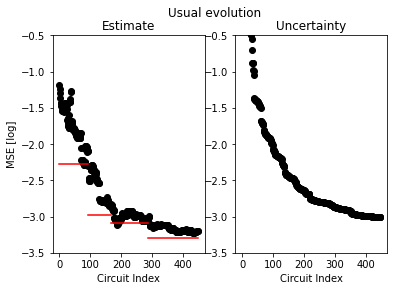

In [16]:
%matplotlib inline
plt_spacing = 1
yrange = [-3.5, -0.5]
make_error_plot('Usual evolution', usual_parameter_history, mdl_datagen.to_vector(), usual_covar_history, yrange, mle_estimates, germ_length_ranges, plt_spacing)

In [17]:
print(len(edesign.circuit_lists[0]))
print(len(edesign.circuit_lists[-1]))

92
448


## finding the best jacobian

The Kalman update for the covariance is
$$ P_\text{post} = (1 - K_k H_k) P_\text{prior} $$
where the Kalman gain is 
$$ K_k = P_\text{prior} H_k^T (H_k P_{\text{prior}} H_k^T + R_k)^{-1} $$

To estimate circuit shot noise, we'll use a pseduo-count vector:
$$ 
    \vec{\alpha} = N \vec{p}_\text{estimate} + \vec{1}
$$
and the covariance
$$
    R_k = \frac{1}{N+d+1} \bigg( \frac{\text{diag}( \vec{\alpha}) }{N+d} - \frac{ \alpha \alpha^T}{(N+d)^2} \bigg)
$$

In [18]:
mdl_datagen.probabilities((edesign.circuit_lists[0])[0])

OutcomeLabelDict([(('0',), 0.8885419872030156), (('1',), 0.11145801279698431)])

In [19]:
def find_best_circuit(circ_list, model, covar, num_shots):
    """
    The simpliest function to find the best next circuit
        
    We estimate the observation noise for each circuit using the filter's prediction
    
    The algo is to go through each circuit and assign a score per:
        1) estimate the sampling noise
        2) calculate the model jacobian
        3) calculate the kgain
        4) assign a score per the trace of (1-KH)P
    Pick the smallest score
    """
    
    traces = dict()
    for circ in circ_list:
        hdims = 2**circ.width
        # simulate circuit probs
        p_model = vector_from_outcomes(model.probabilities(circ), hdims)
        # estimate sampling covar
        pseudo_counts = num_shots*p_model + np.ones(hdims)
        sampling_covar = (1/(num_shots + hdims + 1)) * (
            np.diag(pseudo_counts)/(num_shots + hdims) + 
            np.outer(pseudo_counts, pseudo_counts)/(num_shots + hdims)**2
        )
        # calculate kgain
        jac = matrix_from_jacob(model.sim.dprobs(circ), hdims) 
        kgain = covar@jac.T@np.linalg.pinv(jac@covar@jac.T + sampling_covar)
        # find the resulting posterior covariance
        post_covar = (np.eye(covar.shape[0]) - kgain@jac)@covar
        traces[circ] = np.trace(post_covar)
    min_trace_val = min(traces.values())
    best_circuits = [key for key in traces if traces[key] == min_trace_val]
    return best_circuits[0], traces


  0%|                                                                                                                                                                                                                | 0/100 [00:08<?, ?it/s]


MSE:  0.06636360731238913
Best circ:  Qubit 0 ---|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|---

Predicted covar:  0.17000018403525344


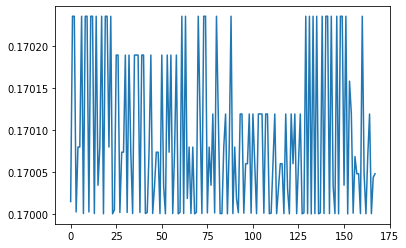

MSE:  0.058173703154237776
Best circ:  Qubit 0 ---|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|---

Predicted covar:  0.16001223463382003


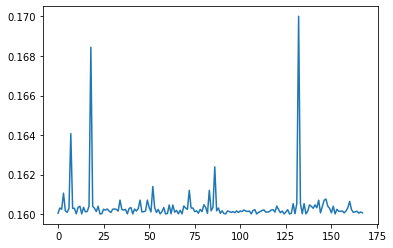

MSE:  0.058691173898048114
Best circ:  Qubit 0 ---| |-| |---

Predicted covar:  0.150030230304204


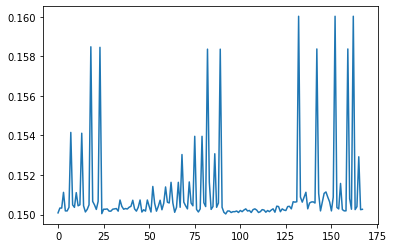

MSE:  0.04549084751972132
Best circ:  Qubit 0 ---|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|---

Predicted covar:  0.1402120778715008


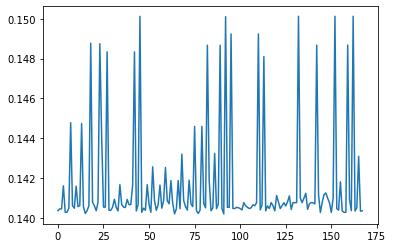

MSE:  0.038048999044493985
Best circ:  Qubit 0 ---|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|---

Predicted covar:  0.13026006264272494


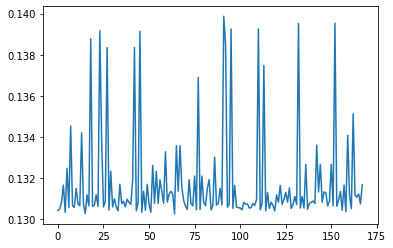

MSE:  0.03700899042420735
Best circ:  Qubit 0 -----

Predicted covar:  0.12051508335608294


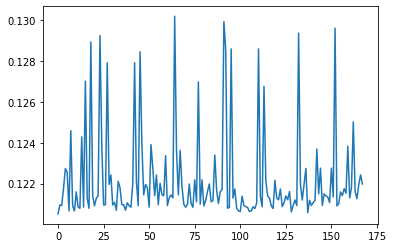

MSE:  0.03458163354711018
Best circ:  Qubit 0 ---|Gypi2|-| |-| |-|Gxpi2|---

Predicted covar:  0.11120087271928572


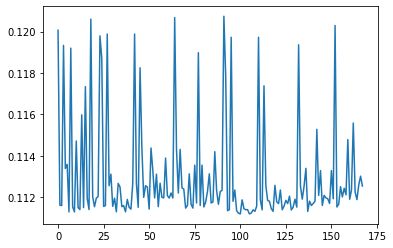

MSE:  0.03488357811519569
Best circ:  Qubit 0 ---|Gxpi2|-| |-| |-|Gxpi2|---

Predicted covar:  0.10164559473415574


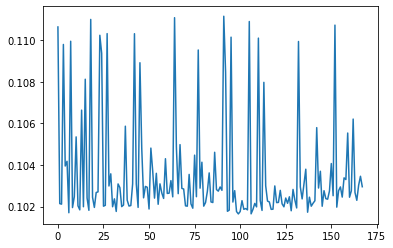

MSE:  0.04063245667449013
Best circ:  Qubit 0 ---|Gxpi2|-|Gypi2|---

Predicted covar:  0.09223106317527188


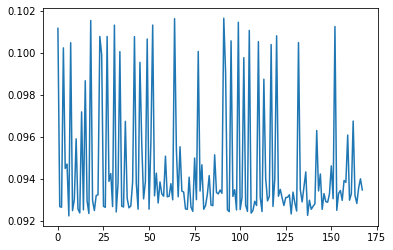

MSE:  0.03503872249952072
Best circ:  Qubit 0 ---|Gxpi2|-|Gypi2|-|Gypi2|-|Gxpi2|---

Predicted covar:  0.08276640711800913


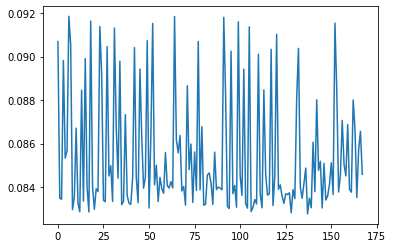

  0%|                                                                                                                                                                                                                 | 0/10 [01:02<?, ?it/s]


In [22]:
%matplotlib inline
# try it out starting from a gaussian at the target
num_updates = 10
show_output = True

circ_list = edesign.circuit_lists[1] # just do length 1 and 2 germs for this example

covar = 0.01*np.eye(target_model.num_params)
ekf = ExtendedKalmanFilter(target_model, covar)

adaptive_parameter_history = []
adaptive_covar_history = []

pbar = tqdm(total=num_updates)


current_update = 0
while(current_update < num_updates):
    circ, traces = find_best_circuit(circ_list, ekf.model, ekf.P, NUM_SHOTS)
    if show_output:
        print('MSE: ', mserror(ekf.model, mdl_datagen))
        print('Best circ: ', circ)
        print('Predicted covar: ', traces[circ])

        plt.plot([v for v in traces.values()])
        plt.show()
    else:
        # show progress if not output
        pbar.update(1)
        
    cvec = vector_from_outcomes(dataset[circ].counts, 2**circ.width)
    ekf.update(circ, cvec)
    adaptive_parameter_history.append(ekf.model.to_vector())
    adaptive_covar_history.append(ekf.P)    
    
    current_update += 1
pbar.close()

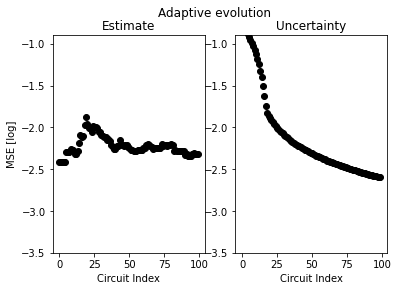

In [111]:
yrange = [-3.5, -0.5]
make_error_plot('Adaptive evolution', adaptive_parameter_history, mdl_datagen.to_vector(), adaptive_covar_history, yrange, None, germ_length_ranges, 1)

In [30]:
print('mse of target with datagen', np.log10(mserror(target_model, mdl_datagen)))
print('mse of final mle with datagen', np.log10(mserror(mdl_datagen, mle_estimates[-1])))
print('mse of adaptive filter estimate with datagen', np.log10(mserror(ekf.model, mdl_datagen)))

mse of target with datagen -1.4293414708712984
mse of final mle with datagen -3.299098379531565
mse of adaptive filter estimate with datagen -1.4293414708712984


# Warm starting it

In [32]:
# try warm starting by running all germ length 1 circuits then doing adaptive filtering
# run a Kalman filter in the usual way on all germ length 1 circuits
prior_covar = 0.1*np.eye(target_model.num_params)
germ1_model, germ1_covar, saved_data = filter_dataset(target_model, prior_covar, dataset, edesign.circuit_lists[0], 
    None, None, clip_range=[-1, 1],
    max_itr=1, itr_eps=1e-4,
    save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:03<00:00, 26.15it/s]


  0%|                                                                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

MSE:  0.007148203355764896
Best circ:  Qubit 0 ---|Gxpi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gxpi2|---

Predicted covar:  0.010974950162433106


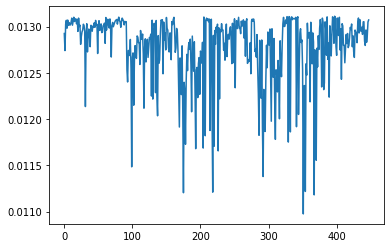

MSE:  0.006834309317979515
Best circ:  Qubit 0 ---|Gxpi2|-| |-| |-| |-| |-|Gxpi2|---

Predicted covar:  0.009097176181723574


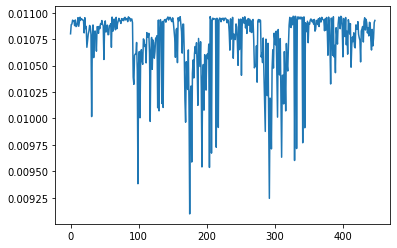

MSE:  0.006444229208012316
Best circ:  Qubit 0 ---|Gypi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gypi2|---

Predicted covar:  0.0077011566638542596


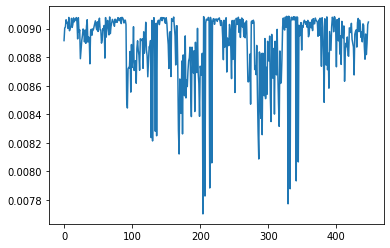

MSE:  0.004368502022613244
Best circ:  Qubit 0 ---| |-| |-| |-| |-| |-| |-| |-| |-|Gxpi2|---

Predicted covar:  0.006646900261121441


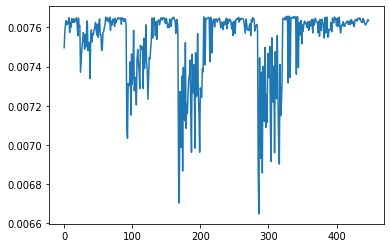

MSE:  0.004471603127647589
Best circ:  Qubit 0 ---| |-| |-| |-| |-| |-| |-| |-| |---

Predicted covar:  0.005835845130653742


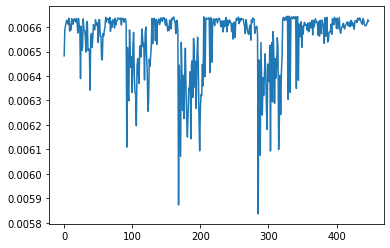

In [ ]:
# now swtich to adaptive filtering
num_updates = 100
show_output = True

circ_list = edesign.circuit_lists[-1] # now all the circuits in the maxlength exp

ekf = ExtendedKalmanFilter(germ1_model, germ1_covar)

adaptive_parameter_history = []
adaptive_covar_history = []

pbar = tqdm(total=num_updates)

current_update = 0
while(current_update < num_updates):
    circ, traces = find_best_circuit(circ_list, ekf.model, ekf.P, NUM_SHOTS)
    if show_output:
        print('MSE: ', mserror(ekf.model, mdl_datagen))
        print('Best circ: ', circ)
        print('Predicted covar: ', traces[circ])

        plt.plot([v for v in traces.values()])
        plt.show()
    else:
        # show progress if not output
        pbar.update(1)
        
    cvec = vector_from_outcomes(dataset[circ].counts, 2**circ.width)
    ekf.update(circ, cvec)
    adaptive_parameter_history.append(ekf.model.to_vector())
    adaptive_covar_history.append(ekf.P)    
    
    current_update += 1
pbar.close()

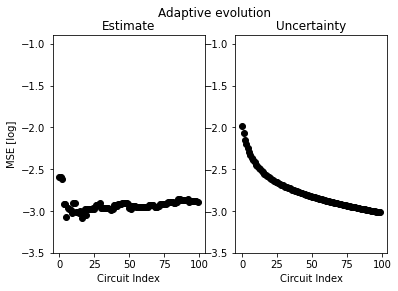

In [120]:
yrange = [-3.5, -0.9]
make_error_plot('Adaptive evolution', adaptive_parameter_history, mdl_datagen.to_vector(), adaptive_covar_history, yrange, None, germ_length_ranges, 1)